In [2]:
import xml.etree.ElementTree as ET
import numpy as np

def parse_inkml(file_path):
    """
    Parse an InkML file and return:
    - strokes: a list of numpy arrays (each is a stroke of shape [n_points, 2])
    - label: the LaTeX label (ground truth) if available
    """
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Handling namespaces (InkML files typically use a default InkML namespace)
    ns = {'ink': 'http://www.w3.org/2003/InkML'}
    
    # Get annotation (if present)
    label = None
    for annotation in root.findall('ink:annotation', ns):
        # Choose normalizedLabel if available; fallback to label
        if annotation.get('type') == 'normalizedLabel':
            label = annotation.text.strip()
            break
        elif annotation.get('type') == 'label':
            label = annotation.text.strip()
    
    strokes = []
    # Each <trace> element contains a stroke
    for trace in root.findall('ink:trace', ns):
        trace_data = trace.text.strip()
        points = []
        # InkML usually separates points by commas and coordinates by space
        for point_str in trace_data.split(','):
            # Remove extra spaces and split by whitespace
            coords = point_str.strip().split()
            if len(coords) >= 2:
                x, y = float(coords[0]), float(coords[1])
                points.append([x, y])
        if points:
            strokes.append(np.array(points))
    
    return strokes, label

# Example usage:
strokes, label = parse_inkml('./data/mathwriting-2024/mathwriting-2024/train/51b364eb9ba2185a.inkml')
print("Parsed {} strokes".format(len(strokes)))
print("Label:", label)


Parsed 25 strokes
Label: f(x)=\frac{1}{e}\cdot\sum_{n=0}^{\infty}\frac{n^{x}}{n!}


In [3]:
def preprocess_strokes(strokes, max_length=100):
    """
    Normalize and pad strokes to ensure a consistent input shape.
    - Normalizes (X, Y) coordinates.
    - Pads/truncates strokes to max_length.
    """
    all_points = np.concatenate(strokes, axis=0) if strokes else np.array([[0, 0]])
    
    # Normalize X and Y to [0,1] range
    min_vals = np.min(all_points, axis=0)
    max_vals = np.max(all_points, axis=0)
    norm_strokes = [(s - min_vals) / (max_vals - min_vals + 1e-5) for s in strokes]
    
    # Flatten strokes and pad/truncate to fixed size
    flat_strokes = np.concatenate(norm_strokes, axis=0)[:max_length]
    pad_length = max_length - len(flat_strokes)
    padded_strokes = np.pad(flat_strokes, ((0, pad_length), (0, 0)), mode='constant')
    
    return padded_strokes


In [5]:
import os
def load_dataset(inkml_dirs, num_files=1000, max_length=100):
    samples = []
    labels = []
    charset = set()

    for root_dir in inkml_dirs:
        if num_files == 'None' :
            files = [f for f in os.listdir(root_dir) if f.endswith('.inkml')]
        else:
            files = [f for f in os.listdir(root_dir) if f.endswith('.inkml')][:num_files]  # Limit files
            
        for file in files:
            path = os.path.join(root_dir, file)
            strokes, label = parse_inkml(path)
            
            if strokes and label:
                processed_strokes = preprocess_strokes(strokes, max_length)
                samples.append(processed_strokes)
                labels.append(label)
                charset.update(label)

    # Create character mappings
    char2idx = {c: i + 1 for i, c in enumerate(sorted(charset))}
    char2idx['<pad>'] = 0
    idx2char = {v: k for k, v in char2idx.items()}

    return samples, labels, char2idx, idx2char

In [7]:
num_files = 49984  # Get value from slider
samples, labels, char2idx, idx2char = load_dataset(['./data/mathwriting-2024/mathwriting-2024/train'], num_files=num_files)
print(f"Loaded {len(samples)} samples")

Loaded 49984 samples


In [8]:
char2idx

{' ': 1,
 '!': 2,
 '#': 3,
 '%': 4,
 '&': 5,
 '(': 6,
 ')': 7,
 '*': 8,
 '+': 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '<': 26,
 '=': 27,
 '>': 28,
 '?': 29,
 'A': 30,
 'B': 31,
 'C': 32,
 'D': 33,
 'E': 34,
 'F': 35,
 'G': 36,
 'H': 37,
 'I': 38,
 'J': 39,
 'K': 40,
 'L': 41,
 'M': 42,
 'N': 43,
 'O': 44,
 'P': 45,
 'Q': 46,
 'R': 47,
 'S': 48,
 'T': 49,
 'U': 50,
 'V': 51,
 'W': 52,
 'X': 53,
 'Y': 54,
 'Z': 55,
 '[': 56,
 '\\': 57,
 ']': 58,
 '^': 59,
 '_': 60,
 'a': 61,
 'b': 62,
 'c': 63,
 'd': 64,
 'e': 65,
 'f': 66,
 'g': 67,
 'h': 68,
 'i': 69,
 'j': 70,
 'k': 71,
 'l': 72,
 'm': 73,
 'n': 74,
 'o': 75,
 'p': 76,
 'q': 77,
 'r': 78,
 's': 79,
 't': 80,
 'u': 81,
 'v': 82,
 'w': 83,
 'x': 84,
 'y': 85,
 'z': 86,
 '{': 87,
 '|': 88,
 '}': 89,
 '<pad>': 0}

In [9]:
num_test_files = 9984   # Get value from slider
test_samples, test_labels, test_char2idx, test_idx2char = load_dataset(['./data/mathwriting-2024/mathwriting-2024/valid'], num_files=num_test_files)
print(f"Loaded {len(test_samples)} samples")

Loaded 9984 samples


In [11]:
# Convert strokes (samples) into a padded sequence format
import tensorflow as tf

def preprocess(samples, labels, char2idx):
    # max_seq_length = max(len(s) for s in samples)
    target_seq_length = 110  # Find the longest stroke sequence
    padded_samples = np.array([
        np.pad(s, ((0, max(0, target_seq_length - len(s))), (0, 0)), mode='constant')[:target_seq_length]
        for s in samples
    ])
    
    # Ensure padded_samples has shape (batch_size, 110, features)
    padded_samples = np.pad(padded_samples, ((0, 0), (0, 0), (0, 1)), mode='constant')

    # Convert labels into numerical format using char2idx
    numerical_labels = [[char2idx[c] for c in label] for label in labels]

    # Pad label sequences
    max_label_length = max(
    max(len(label) for label in labels),
    max(len(label) for label in test_labels))
    # Pad label sequences
    padded_labels = tf.keras.preprocessing.sequence.pad_sequences(
        numerical_labels, maxlen=max_label_length, padding='post'
    )
    # padded_labels = tf.keras.preprocessing.sequence.pad_sequences(numerical_labels, padding='post')

    # Convert to TensorFlow datasets for efficient loading
    # BATCH_SIZE = 32           

    # train_dataset = tf.data.Dataset.from_tensor_slices((padded_samples, padded_labels))
    # train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    # return train_dataset
    return padded_samples, padded_labels


In [26]:
train_X, train_y = preprocess(samples, labels, char2idx)
val_X, val_y = preprocess(test_samples, test_labels, test_char2idx)
# train_data = preprocess(samples, labels, char2idx)
# val_data = preprocess(test_samples, test_labels, test_char2idx)


In [27]:
val_X.shape

(9984, 110, 3)

In [28]:
val_y.shape

(9984, 128)

In [29]:
# print(model.input_shape)


In [30]:
start_token = 0  # Define the start token (adjust based on your dataset)

# Shift train_y one step to the right and add start_token at the beginning
train_decoder_inputs = np.pad(train_y[:, :-1], ((0, 0), (1, 0)), constant_values=start_token)
val_decoder_inputs = np.pad(val_y[:, :-1], ((0, 0), (1, 0)), constant_values=start_token)


In [31]:
print("train_X shape:", train_X.shape)  # (batch_size, time_steps, features)
print("train_decoder_inputs shape:", train_decoder_inputs.shape)  # (batch_size, max_length)
print("train_y shape:", train_y.shape)  # (batch_size, max_length)


train_X shape: (49984, 110, 3)
train_decoder_inputs shape: (49984, 188)
train_y shape: (49984, 188)


In [33]:
MAX_TIME_STEPS = 128  # Match encoder's time steps
train_decoder_inputs = train_decoder_inputs[:, :MAX_TIME_STEPS]
train_y = train_y[:, :MAX_TIME_STEPS]
val_decoder_inputs = val_decoder_inputs[:, :MAX_TIME_STEPS]
val_y = val_y[:, :MAX_TIME_STEPS]


In [34]:
print("train_X shape:", train_X.shape)  # (batch_size, time_steps, features)
print("train_decoder_inputs shape:", train_decoder_inputs.shape)  # (batch_size, max_length)
print("train_y shape:", train_y.shape)  # (batch_size, max_length)
print(f"val_X shape: {val_X.shape}")
print(f"val_decoder_inputs shape: {val_decoder_inputs.shape}")
print(f"val_y shape: {val_y.shape}")


train_X shape: (49984, 110, 3)
train_decoder_inputs shape: (49984, 128)
train_y shape: (49984, 128)
val_X shape: (9984, 110, 3)
val_decoder_inputs shape: (9984, 128)
val_y shape: (9984, 128)


# Experiment 1 baseline model

In [48]:
import tensorflow as tf

# Configuration
vocab_size = 100  # Adjust based on dataset
embed_size = 128
hidden_size = 256
max_length = 150  # Max sequence length

# Encoder
encoder_inputs = tf.keras.Input(shape=(None, 3))  # (time steps, features)
encoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
encoder_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
encoder_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [encoder_state_h, encoder_state_c]

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size)
decoder_embedded = embedding_layer(decoder_inputs)

# Match the dimensions using a Dense layer to project the encoder outputs to 128 dimensions
encoder_projection = tf.keras.layers.Dense(128, activation="tanh")(encoder_outputs)

# Attention Mechanism
attention = tf.keras.layers.AdditiveAttention()
context_vector = attention([decoder_embedded, encoder_projection])

# Proper Concatenation Before Passing to LSTM
decoder_lstm = tf.keras.layers.LSTM(hidden_size * 2, return_sequences=True, return_state=True)
decoder_lstm_input = tf.keras.layers.Concatenate(axis=-1)([decoder_embedded, context_vector])
decoder_outputs, _, _ = decoder_lstm(decoder_lstm_input, initial_state=encoder_states)

# Output Layer
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')
decoder_outputs = output_layer(decoder_outputs)

# Full Model
# def ctc_loss_function(y_true, y_pred):
#     return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])


In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint

BATCH_SIZE = 64
EPOCHS = 10

# Define checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    "best_model.h5",  # Save the best model to this file
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize validation accuracy
    verbose=1
)

In [59]:
# Train the model with validation data and checkpointing
history0 = model.fit(
    x=[train_X, train_decoder_inputs],  # Encoder and decoder inputs
    y=train_y,  # Decoder targets
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_X, val_decoder_inputs], val_y),  # Add validation set
    callbacks=[checkpoint_callback]  # Include checkpoint callback
)

# Save the final trained model
model.save("final_model.h5")


Epoch 1/10
156/156 [==============================] - 26s 123ms/step - loss: 0.9404 - sparse_categorical_accuracy: 0.7941 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.8384
Epoch 2/10
156/156 [==============================] - 19s 119ms/step - loss: 0.6162 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.4782 - val_sparse_categorical_accuracy: 0.8882
Epoch 3/10
156/156 [==============================] - 19s 121ms/step - loss: 0.4489 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.3890 - val_sparse_categorical_accuracy: 0.9074
Epoch 4/10
156/156 [==============================] - 20s 131ms/step - loss: 0.3817 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.3445 - val_sparse_categorical_accuracy: 0.9183
Epoch 5/10
156/156 [==============================] - 37s 240ms/step - loss: 0.3448 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.3152 - val_sparse_categorical_accuracy: 0.9243
Epoch 6/10
156/156 [==============================] - 34s 218ms/step - loss: 0.3200 -

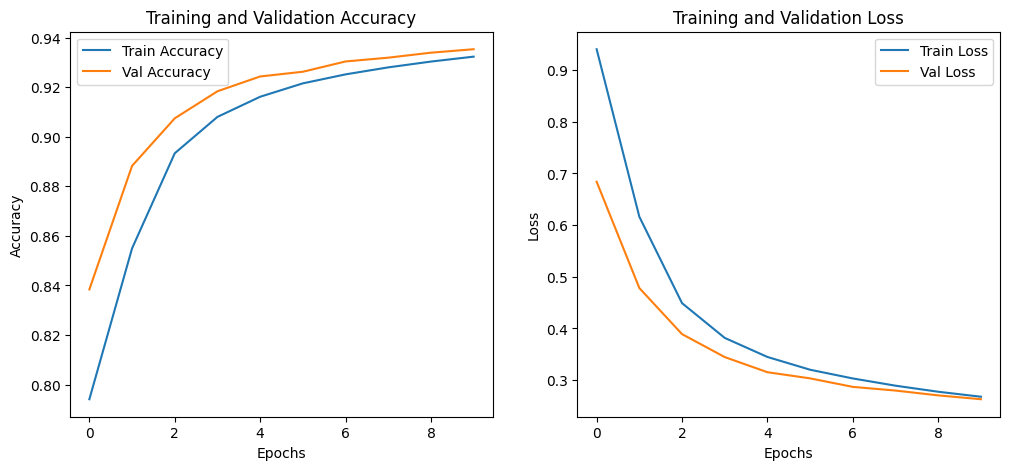

In [62]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history0.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history0.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history0.history['loss'], label='Train Loss')
plt.plot(history0.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

# Show the plots
plt.show()


In [79]:
train_loss, train_acc = model.evaluate([train_X, train_decoder_inputs], train_y)
print(f"Train Accuracy: {train_acc:.4f}")


2/2 [==============================] - 1s 21ms/step - loss: 1.4369 - sparse_categorical_accuracy: 0.7294
Train Accuracy: 0.7294


In [80]:
val_loss, val_acc = model.evaluate([val_X, val_decoder_inputs], val_y)
print(f"Validation Accuracy: {val_acc:.4f}")


2/2 [==============================] - 1s 28ms/step - loss: 2.0674 - sparse_categorical_accuracy: 0.6078
Validation Accuracy: 0.6078


In [65]:
predictions = model.predict([train_X, train_decoder_inputs])
predicted_token_ids = np.argmax(predictions, axis=-1)  # Shape: (batch_size, seq_len)

# Print an example
# for i in range(0,64):
print(predictions[1])  # First sample in batch

312/312 [==============================] - 8s 22ms/step
[[5.4792978e-04 7.6873093e-06 6.7236018e-05 ... 3.1008763e-05
  2.3881621e-05 2.9378032e-05]
 [1.9139277e-05 9.5155237e-06 2.1457023e-05 ... 4.8127954e-06
  3.3207671e-06 2.0966156e-06]
 [2.0377896e-05 1.1850453e-04 3.8244302e-06 ... 1.4725570e-07
  7.2261862e-08 6.2675525e-08]
 ...
 [9.9999213e-01 7.9076310e-09 3.5354134e-08 ... 1.9305195e-11
  4.5676830e-12 8.5746878e-12]
 [9.9999225e-01 7.9170484e-09 3.5099688e-08 ... 1.9227880e-11
  4.5552251e-12 8.5610104e-12]
 [9.9999225e-01 7.9362650e-09 3.4866019e-08 ... 1.9160298e-11
  4.5447673e-12 8.5518060e-12]]


In [ ]:
# def predict_sequence(model, encoder_input, vocab_size, max_length):
#     """Generates a sequence step by step"""
#     decoder_input = np.zeros((1, 1))  # Start token
#     predictions = []

#     for _ in range(max_length):
#         output = model.predict([encoder_input, decoder_input])
#         predicted_id = np.argmax(output[0, -1, :])  # Get most likely token

#         if predicted_id == 0:  # Stop if PAD token is predicted
#             break

#         predictions.append(predicted_id)

#         # Update decoder input for next step
#         decoder_input = np.hstack([decoder_input, np.array([[predicted_id]])])

#     return predictions

# # Test on first sample
# predicted_ids = predict_sequence(model, train_X[0:1], vocab_size, max_length)
# print("Predicted Token IDs:", predicted_ids)


1/1 [==============================] - 0s 55ms/step
Predicted Token IDs: [57, 79, 77, 78, 80, 87, 57, 66, 78, 61, 63, 87, 57, 79, 77, 78, 80, 87, 17, 89, 89, 87, 16, 89, 89, 87, 57, 66, 78, 61, 63, 87, 15, 89, 87, 17, 89, 89]


In [67]:
print("Context Vector Shape:", context_vector.shape)

Context Vector Shape: (None, None, 128)


In [68]:
train_y.shape

(9984, 128)

In [69]:
predictions.shape

(9984, 128, 100)

In [77]:
train_y[5]

array([30, 27, 57, 76, 78, 75, 64, 60, 87, 69, 27, 15, 89, 59, 87, 74, 89,
       30, 60, 87, 69, 89,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
predicted_token_ids[5]

array([57, 27, 57, 66, 78, 75, 64, 60, 87, 69, 27, 15, 89, 59, 87, 74, 89,
       57, 60, 87, 69, 89,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [14]:
def convert_predictions_to_latex(predictions, idx2char):
    """
    Convert a sequence of predicted token IDs into a LaTeX equation.

    Args:
        predictions (list or np.array): List of predicted token IDs.
        idx2char (dict): Dictionary mapping token IDs to LaTeX tokens.

    Returns:
        str: LaTeX formatted equation.
    """
    latex_tokens = [idx2char.get(token, "") for token in predictions if token in idx2char]
    latex_expression = " ".join(latex_tokens)  # Join tokens with space for readability
    return f"\\[{latex_expression}\\]"  # Wrap with LaTeX math mode delimiters

In [ ]:
# p = np.array([79, 13, 12, 51, 79, 14, 13, 20, 81, 81, 51, 79, 13, 12, 81,  9, 49,
#        58, 70, 53, 55, 79, 49, 58, 70, 53, 55, 79, 16, 81, 79, 49, 71, 69,
#        70, 72, 79, 15, 19, 17, 81, 81, 81, 79, 13, 19, 21, 81,  0,  0,  0,
#         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
#         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
#         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
# predicted_token_ids[5]
# train_y[5]
latex_equation = convert_predictions_to_latex(predicted_token_ids[5], idx2char)
latex_equation

'\\[\\ = \\ f r o d _ { i = 1 } ^ { n } \\ _ { i } <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>\\]'

In [80]:
latex_equation = convert_predictions_to_latex(train_y[5], idx2char)
latex_equation

'\\[A = \\ p r o d _ { i = 1 } ^ { n } A _ { i } <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>\\]'

Now For Second experiment training images 10,000 -> 50,000 (approx)
and validation set is same but in next experiment we will used diffrent metrics edit distance metrics

# Experiment 2

In [35]:
import tensorflow as tf

# Configuration
vocab_size = 100  # Adjust based on dataset
embed_size = 128
hidden_size = 256
max_length = 150  # Max sequence length

# Encoder
encoder_inputs = tf.keras.Input(shape=(None, 3))  # (time steps, features)
encoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
encoder_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
encoder_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [encoder_state_h, encoder_state_c]

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size)
decoder_embedded = embedding_layer(decoder_inputs)

# Match the dimensions using a Dense layer to project the encoder outputs to 128 dimensions
encoder_projection = tf.keras.layers.Dense(128, activation="tanh")(encoder_outputs)

# Attention Mechanism
attention = tf.keras.layers.AdditiveAttention()
context_vector = attention([decoder_embedded, encoder_projection])

# Proper Concatenation Before Passing to LSTM
decoder_lstm = tf.keras.layers.LSTM(hidden_size * 2, return_sequences=True, return_state=True)
decoder_lstm_input = tf.keras.layers.Concatenate(axis=-1)([decoder_embedded, context_vector])
decoder_outputs, _, _ = decoder_lstm(decoder_lstm_input, initial_state=encoder_states)

# Output Layer
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')
decoder_outputs = output_layer(decoder_outputs)

# Full Model
# def ctc_loss_function(y_true, y_pred):
#     return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint

BATCH_SIZE = 64
EPOCHS = 10

# Define checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    "exp_2_callback.h5",  # Save the best model to this file
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize validation accuracy
    verbose=1
)

In [37]:
BATCH_SIZE = 128
# Train the model with validation data and checkpointing
history0 = model.fit(
    x=[train_X, train_decoder_inputs],  # Encoder and decoder inputs
    y=train_y,  # Decoder targets
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([val_X, val_decoder_inputs], val_y),  # Add validation set
    callbacks=[checkpoint_callback]  # Include checkpoint callback
)

# Save the final trained model
model.save("exp2.h5")


Epoch 1/10
391/391 [==============================] - 73s 167ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.3767 - val_sparse_categorical_accuracy: 0.9100
Epoch 2/10
391/391 [==============================] - 64s 163ms/step - loss: 0.3381 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.2915 - val_sparse_categorical_accuracy: 0.9295
Epoch 3/10
391/391 [==============================] - 64s 163ms/step - loss: 0.2840 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.2617 - val_sparse_categorical_accuracy: 0.9355
Epoch 4/10
391/391 [==============================] - 64s 164ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.9348 - val_loss: 0.2443 - val_sparse_categorical_accuracy: 0.9388
Epoch 5/10
391/391 [==============================] - 64s 164ms/step - loss: 0.2387 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.2326 - val_sparse_categorical_accuracy: 0.9412
Epoch 6/10
391/391 [==============================] - 63s 162ms/step - loss: 0.2226 -

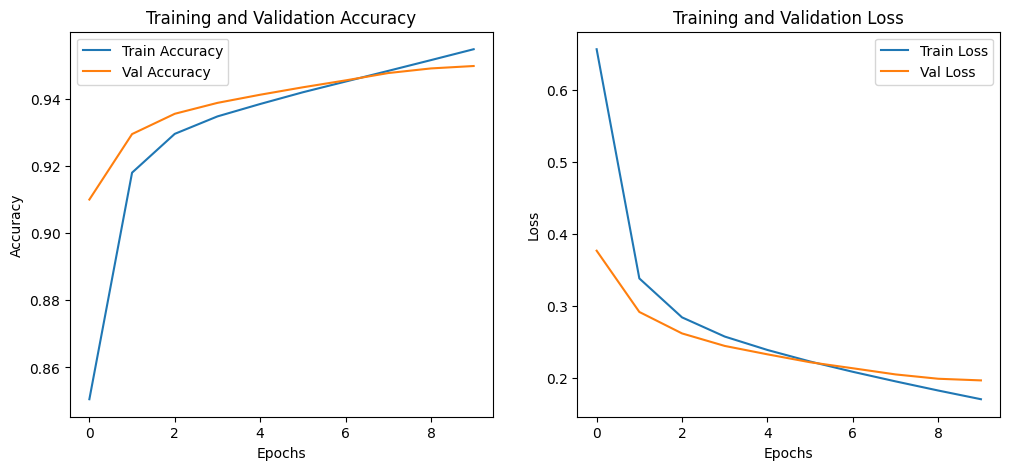

In [38]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history0.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history0.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history0.history['loss'], label='Train Loss')
plt.plot(history0.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

# Show the plots
plt.show()


In [41]:
import tensorflow.keras.backend as K
import gc

K.clear_session()
gc.collect()


3704

In [42]:
predictions = model.predict([val_X, val_decoder_inputs])
predicted_token_ids = np.argmax(predictions, axis=-1)  # Shape: (batch_size, seq_len)

# Print an example
# for i in range(0,64):
print(predictions[1])  # First sample in batch

312/312 [==============================] - 7s 22ms/step
[[1.8703662e-05 7.4754837e-08 5.6773240e-07 ... 4.0629704e-08
  2.5281503e-08 1.4071491e-08]
 [3.2480443e-09 9.4992136e-10 3.2772611e-09 ... 1.4495209e-09
  6.8490896e-10 1.8047460e-09]
 [1.0804875e-07 2.5478345e-08 9.0764258e-09 ... 7.0963129e-09
  6.8742048e-09 1.1527002e-08]
 ...
 [9.9999952e-01 1.6820456e-09 8.6073886e-09 ... 3.7830307e-12
  1.7504464e-12 4.8180336e-12]
 [9.9999952e-01 1.6637498e-09 8.6013978e-09 ... 3.7535339e-12
  1.7406480e-12 4.7817614e-12]
 [9.9999952e-01 1.6495213e-09 8.6016110e-09 ... 3.7287022e-12
  1.7307561e-12 4.7496018e-12]]


In [43]:
print(predicted_token_ids[5])
print(val_y[5])


[57 66 78 61 63 87 15 89 87 57 79 77 78 80 87 57 59 89 87 14 89 89  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
[57 66 78 61 63 87 15 89 87 57 79 77 78 80 87 64 89 60 87 81 89 89  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [44]:
latex_equation = convert_predictions_to_latex(predicted_token_ids[5], idx2char)
latex_equation

'\\[\\ f r a c { 1 } { \\ s q r t { \\ ^ } { 0 } } <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>\\]'

In [46]:
latex_equation = convert_predictions_to_latex(val_y[5], idx2char)
latex_equation

'\\[\\ f r a c { 1 } { \\ s q r t { d } _ { u } } <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>\\]'

In [ ]:
# import tensorflow as tf
# import Levenshtein

# # Custom Edit Distance Metric
# def edit_distance_metric(y_true, y_pred):
#     def compute_distance(y_true_np, y_pred_np):
#         y_true_decoded = "".join([chr(c) for c in y_true_np if c > 0])  # Convert to string
#         y_pred_decoded = "".join([chr(c) for c in y_pred_np if c > 0])  
        
#         dist = Levenshtein.distance(y_true_decoded, y_pred_decoded)
#         max_len = max(len(y_true_decoded), len(y_pred_decoded))
#         return dist / max_len if max_len > 0 else 0  # Normalize

#     return tf.py_function(func=compute_distance, inp=[y_true, y_pred], Tout=tf.float32)

# # Compile model with the custom metric
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[edit_distance_metric])
